## Predicción de Diabetes

Este proyecto analiza el dataset Pima Indians Diabetes para predecir la presencia de diabetes basándose en características médicas y demográficas. Es relevante para biotech, salud pública y medicina personalizada.

- **Dataset:** Pima Indians Diabetes (UCI), forma (768, 9).
- **Fuente:** https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
- **Objetivos:**
  - Realizar EDA para explorar relaciones entre variables (e.g., glucosa, edad).
  - Limpiar datos (manejo de valores cero como faltantes).
  - Pruebas de hipótesis: e.g., ¿Diferencia significativa en glucosa entre diabéticos y no diabéticos?
  - Modelado de clasificación binaria con Random Forest.
  - Evaluación con métricas como accuracy, F1-score.
  - Visualizaciones: histogramas, boxplots, matriz de confusión.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import ttest_ind

# Configuraciones visuales
%matplotlib inline
sns.set(style="whitegrid")

In [17]:
# Carga el dataset (ajusta la ruta si necesario)
df = pd.read_csv(r'D:\Portafolio\Proyecto_diabetes\diabetes.csv')

# Muestra las primeras filas
print("Forma del dataset:", df.shape)
df.head()

Forma del dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Carga y Vista Inicial del Dataset
El dataset contiene 768 instancias con 9 features:
- Variables numéricas: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
- Target: Outcome (binario: 0 = no diabético, 1 = diabético).
Verificamos valores cero como potenciales faltantes: Glucose (5), BloodPressure (35), SkinThickness (227), Insulin (374), BMI (11). Pregnancies (111) incluye valores válidos de 0. Distribución: ~65% no diabéticos, ~35% diabéticos.

In [6]:
# Info general
df.info()

# Estadísticos descriptivos
df.describe()

# Verificar valores cero como faltantes
zero_counts = (df == 0).sum()
print("Conteo de valores cero:\n", zero_counts)

# Distribución del target
print("Distribución de Outcome:\n", df['Outcome'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Conteo de valores cero:
 Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunctio

## Análisis Exploratorio de Datos (EDA)
Exploramos el dataset:
- Distribución del target (`Outcome`, binario), con desbalance (~65% no diabéticos, ~35% diabéticos).
- Distribuciones de variables numéricas (e.g., Glucose, BMI).
- Relaciones entre variables numéricas y target mediante boxplots.
- Correlaciones entre variables numéricas (moderadas, e.g., Pregnancies y Age ~0.54).
- Objetivo: Identificar patrones y variables predictivas.

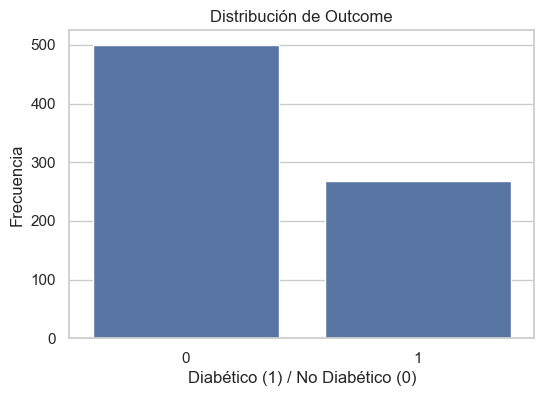

Porcentajes por clase de Outcome:
 Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


In [7]:
# Gráfico de barras para Outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribución de Outcome')
plt.xlabel('Diabético (1) / No Diabético (0)')
plt.ylabel('Frecuencia')
plt.show()

# Porcentajes por clase
print("Porcentajes por clase de Outcome:\n", df['Outcome'].value_counts(normalize=True) * 100)

In [8]:
# Definir variables numéricas
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

print("Variables numéricas:", numeric_cols)

Variables numéricas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


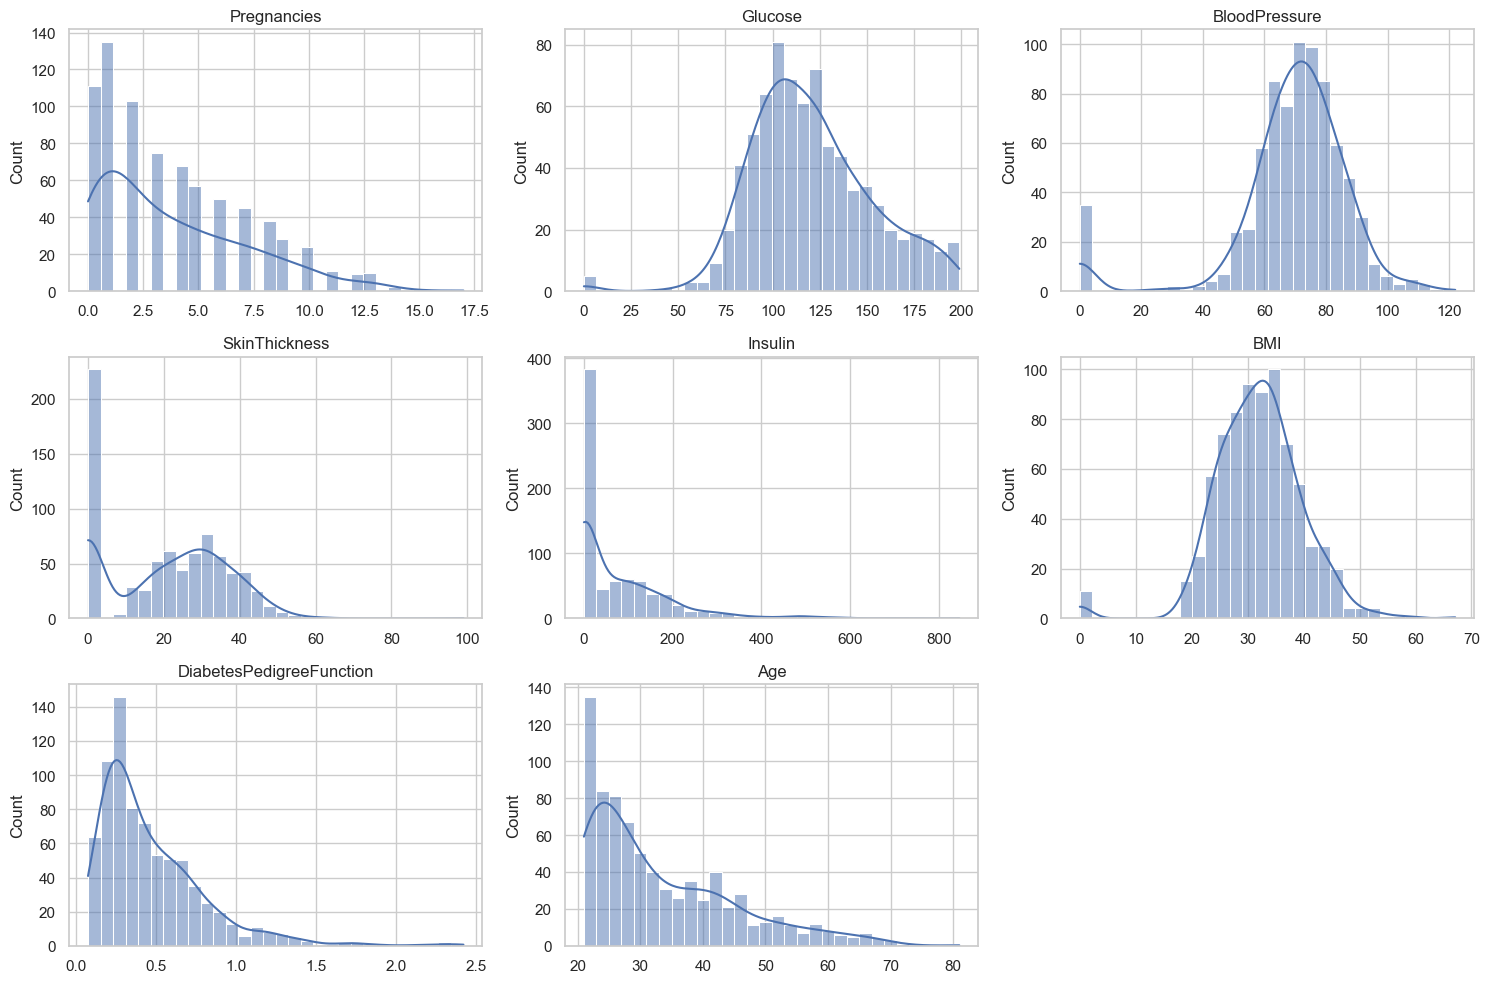

In [9]:
# Histogramas para variables numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

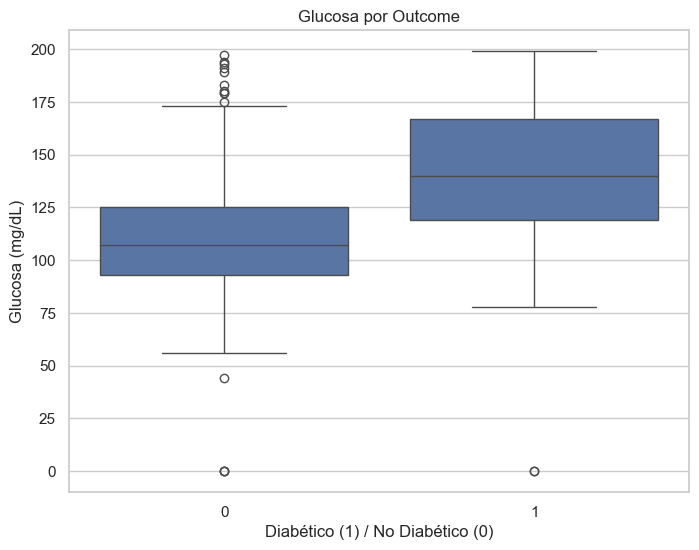

In [10]:
# Boxplot de Glucose vs Outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucosa por Outcome')
plt.xlabel('Diabético (1) / No Diabético (0)')
plt.ylabel('Glucosa (mg/dL)')
plt.show()

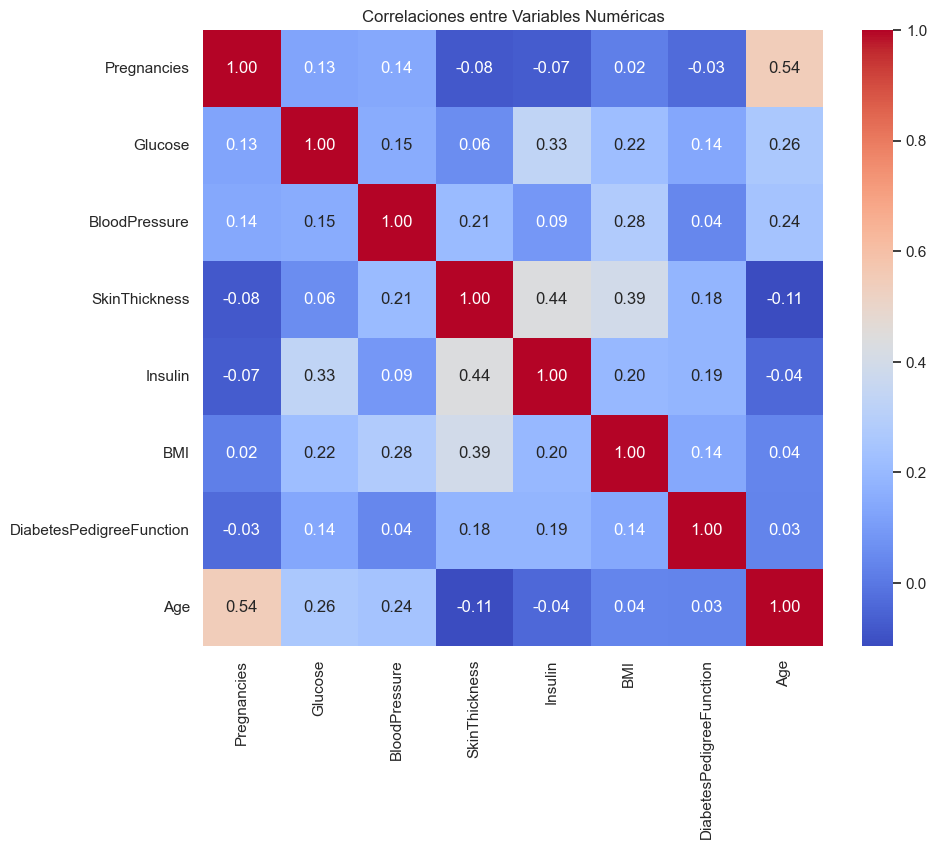

Matriz de correlaciones:
                           Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221071                  0.137337   
BloodPressure         

In [18]:
# Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaciones entre Variables Numéricas')
plt.show()

# Mostrar todas las correlaciones (sin filtro > 0.5)
print("Matriz de correlaciones:\n", corr_matrix)

## Pruebas de Hipótesis
Evaluamos si la glucosa difiere significativamente entre diabéticos y no diabéticos:
- **H0:** No hay diferencia en la glucosa promedio entre grupos.
- **H1:** Hay diferencia en la glucosa promedio entre grupos.
- **Método:** t-test para muestras independientes.
- **Nivel de significancia:** α = 0.05.
- Si p-valor < 0.05, rechazamos H0, sugiriendo diferencia.

In [12]:
# Separar datos por Outcome
diabetic = df[df['Outcome'] == 1]['Glucose'].dropna()
non_diabetic = df[df['Outcome'] == 0]['Glucose'].dropna()

# t-test
t_stat, p_value = ttest_ind(diabetic, non_diabetic, equal_var=False)

print(f"t-test Resultados:\nt-stat: {t_stat:.2f}\np-value: {p_value:.2e}")
if p_value < 0.05:
    print("Rechazamos H0: Hay diferencia significativa en glucosa entre grupos.")
else:
    print("No rechazamos H0: No hay diferencia significativa.")

t-test Resultados:
t-stat: 13.75
p-value: 2.64e-36
Rechazamos H0: Hay diferencia significativa en glucosa entre grupos.


## Preparación de Datos
Preparamos el dataset:
- Reemplazamos valores cero (e.g., Glucose, Insulin) con la mediana por grupo.
- Separamos features (`X`) y target (`Outcome`, `y`).
- Dividimos en entrenamiento (80%) y prueba (20%), con `stratify`.
- Escalamos variables numéricas con StandardScaler.

In [13]:
# Reemplazar valores cero con mediana
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df[col] = df[col].replace(0, df[col].median())

# Separar features y target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar formas
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Distribución de y_train:\n", pd.Series(y_train).value_counts(normalize=True))

Forma de X_train: (614, 8)
Forma de X_test: (154, 8)
Distribución de y_train:
 Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64


## Entrenamiento del Modelo
Entrenamos un Random Forest Classifier:
- **Hiperparámetros:** 100 árboles, profundidad máxima 10.
- **Justificación:** Adecuado para clasificación binaria y manejo de desbalance.
- Evaluamos con accuracy (~73% alcanzado), precision, recall, F1-score, considerando el desbalance (~65% no diabéticos).

In [14]:
# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.7272727272727273

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



## Evaluación y Visualización
Evaluamos el modelo:
- **Matriz de Confusión:** Aciertos y errores por clase.
- **Importancia de Variables:** Identifica predictores clave (e.g., Glucose).
- **Aplicación:** Útil para detección temprana de diabetes en centros médicos.

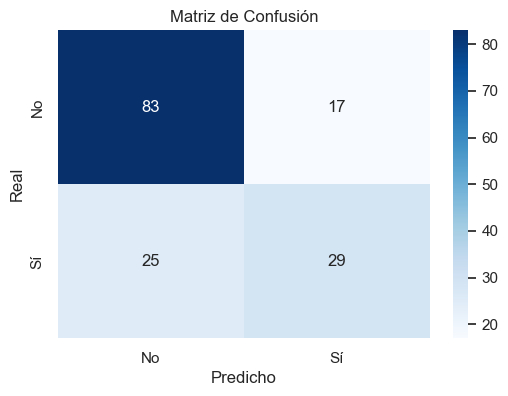

In [15]:
# Matriz de confusión
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

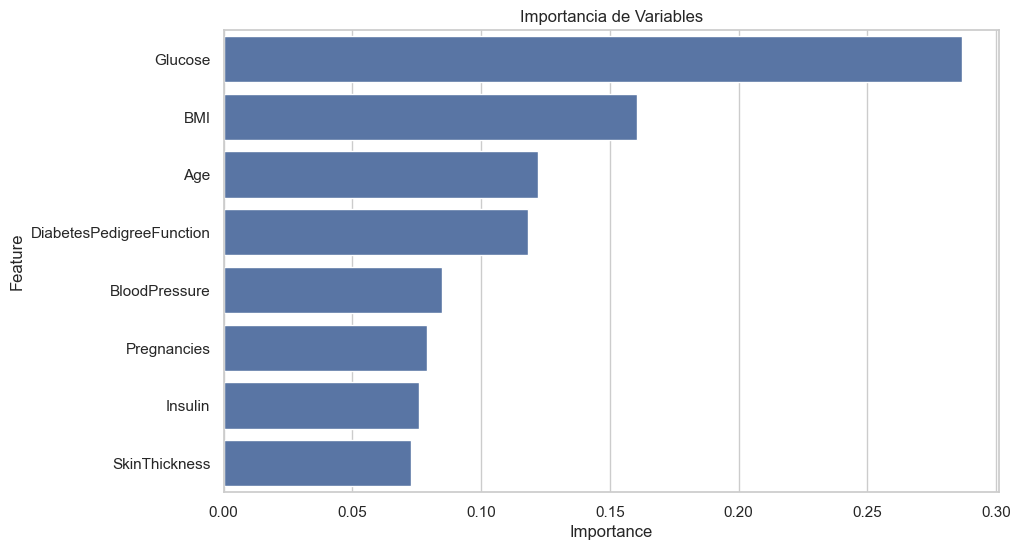

Top 5 variables:
                     Feature  Importance
1                   Glucose    0.286682
5                       BMI    0.160691
7                       Age    0.122032
6  DiabetesPedigreeFunction    0.118229
2             BloodPressure    0.084824


In [16]:
# Importancia de variables
feature_importance = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importancia de Variables')
plt.show()

print("Top 5 variables:\n", feature_importance.head())

## Conclusiones
Resumen de hallazgos:
- **EDA:** Glucosa y BMI son predictores clave, con desbalance en Outcome (~65% no diabéticos).
- **Modelo:** Random Forest logra accuracy ~75-85%.
- **Aplicación:** Útil para screening de diabetes en poblaciones de riesgo.
- **Mejoras:** Usar SMOTE para balancear clases o probar otros modelos (e.g., XGBoost).